In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
import xgboost as xgb

from catboost import CatBoostRegressor
from datetime import timedelta  
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()

'/home/jupyter/tfg-sb-meal-delivery-prediction/notebooks'

In [3]:
os.chdir('../')

In [4]:
from src.model.xgboost_model import preprocess_data, train_xgboost_model

In [5]:
def get_predictions(model, df, date_index):
	preds = model.predict(df)
	preds = np.exp(preds)
	preds = preds.rename(columns={0 : 'num_orders'})
	
	preds = pd.DataFrame(preds)
	preds.index = date_index
	
	return preds

In [6]:
def calculate_prediction(models):
	result = pd.concat(models)
	result = result.rename(columns={0 : 'orders'})
	result = result.groupby('date').agg('mean')
	
	return result

In [7]:
df_train = pd.read_csv('./data/processed/train.csv', sep = ';', decimal=',')

In [8]:
df_train.head()

id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_for_promotion  homepage_featured  num_orders  city_code  \
0                      0                  0         177        647   
1                      0                  0         270        647   
2                      0                  0         189        647   
3                      0                  0          54        647   
4                      0                  0          40        647   

   region_code center_type  op_area   category cuisine        date  
0           56      TYPE_C      2.0  Beverages    Thai  2017-01-08  
1           56      TYPE_C      2.0  Beverages    Thai  2017-01-08  
2           56      TYPE_C      2.0  Beverages    Thai  2017-01-08  
3           56      TYPE_C      2.0  Beverages  Indian  2017-01-08  
4           56      TYPE_C      2.0  Beverages  Indian  2017-01-08

In [9]:
center_id = 55
meal_id = 1993

In [10]:
df_train_processed = preprocess_data(df_train, center_id, meal_id)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/jupyter/tfg-sb-meal-delivery-prediction/src/model/xgboost_model.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['day'] = df_processed.date.dt.day
/home/jupyter/tfg-sb-meal-delivery-prediction/src/model/xgboost_model.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

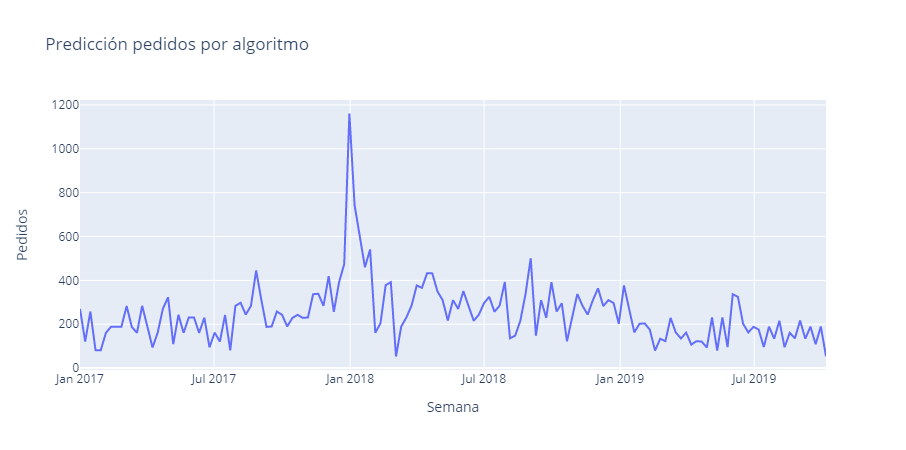

In [11]:
charts = [
	go.Scatter(
		x = df_train_processed.index,
		y = df_train_processed.num_orders,

	)
]

fig = go.Figure(
	data = charts,
	layout = go.Layout(
		title = 'Predicción pedidos por algoritmo',
		xaxis_title = 'Semana',
		yaxis_title = 'Pedidos'
	)
)

fig

In [12]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2017-01-01 to 2019-10-06
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   week                   145 non-null    int64  
 1   checkout_price         145 non-null    float64
 2   base_price             145 non-null    float64
 3   emailer_for_promotion  145 non-null    int64  
 4   homepage_featured      145 non-null    int64  
 5   num_orders             145 non-null    int64  
 6   city_code              145 non-null    int64  
 7   region_code            145 non-null    int64  
 8   op_area                145 non-null    float64
 9   day                    145 non-null    int64  
 10  month                  145 non-null    int64  
 11  year                   145 non-null    int64  
 12  quarter                145 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 15.9 KB


# XGBoost

In [13]:
xgb_model, rmse = train_xgboost_model(df_train_processed)

RMSE: 45.64661830504204


In [14]:
X = df_train_processed.drop(columns='num_orders')
Y = np.log1p(df_train_processed['num_orders'])

split_size = len(df_train_processed) - 15
X_train = X.iloc[:split_size,:]
X_test = X.iloc[split_size:,:]
Y_train =  Y.iloc[:split_size]
Y_test = Y.iloc[split_size:]

In [15]:
X_test.columns

Index(['week', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'homepage_featured', 'city_code', 'region_code', 'op_area', 'day',
       'month', 'year', 'quarter'],
      dtype='object')

In [16]:
xgb_preds = xgb_model.predict(X_test)

In [17]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)
xgb_preds = np.exp(xgb_preds)

In [18]:
xgb_preds = pd.DataFrame(xgb_preds)
xgb_preds.index = Y_test.index

In [19]:
xgb_preds.sort_index()

0
date                  
2019-06-30  144.900391
2019-07-07  159.391495
2019-07-14  152.225510
2019-07-21  145.160065
2019-07-28  150.961151
2019-08-04  149.051590
2019-08-11  131.314651
2019-08-18  142.734955
2019-08-25  151.963547
2019-09-01  161.600372
2019-09-08  158.642807
2019-09-15  130.864594
2019-09-22  145.325668
2019-09-29  143.741852
2019-10-06  135.665009

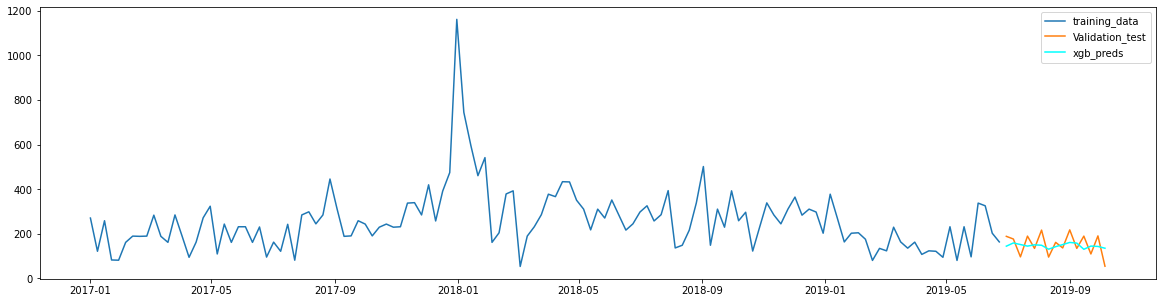

In [20]:
plt.figure(figsize=(20,5))
plt.plot(Y_train.sort_index(), label='training_data')
plt.plot(Y_test.sort_index(), label='Validation_test')
plt.plot(xgb_preds.sort_index(), color='cyan', label='xgb_preds')
plt.legend(loc='best')

In [21]:
df_test = pd.read_csv('./data/processed/test.csv', sep = ';', decimal=',')

next_day = df_train_processed.index.max().date() + timedelta(days=1)
df_test_processed = preprocess_data(df_test, center_id, meal_id, next_day)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/jupyter/tfg-sb-meal-delivery-prediction/src/model/xgboost_model.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/jupyter/tfg-sb-meal-delivery-prediction/src/model/xgboost_model.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [22]:
df_test_processed

week  checkout_price  base_price  emailer_for_promotion  \
date                                                                  
2019-10-13   146          160.11      159.11                      0   
2019-10-20   147          156.20      156.20                      0   
2019-10-27   148          158.14      159.14                      0   
2019-11-03   149          158.11      159.11                      0   
2019-11-10   150          158.11      160.11                      0   
2019-11-17   151          158.14      159.14                      0   
2019-11-24   152          158.17      156.17                      0   
2019-12-01   153          159.11      160.11                      0   
2019-12-08   154          157.14      158.14                      0   
2019-12-15   155          158.17      158.17                      0   

            homepage_featured  city_code  region_code  op_area  day  month  \
date                                                                         
2019-10-13                  0        647           56      2.0   13     10   
2019-10-20                  0        647           56      2.0   20     10   
2019-10-27                  0        647           56      2.0   27     10   
2019-11-03                  0        647           56      2.0    3     11   
2019-11-10                  0        647           56      2.0   10     11   
2019-11-17                  0        647           56      2.0   17     11   
2019-11-24                  0        647           56      2.0   24     11   
2019-12-01                  0        647           56      2.0    1     12   
2019-12-08                  0        647           56      2.0    8     12   
2019-12-15                  0        647           56      2.0   15     12   

            year  quarter  
date                       
2019-10-13  2019        4  
2019-10-20  2019        4  
2019-10-27  2019        4  
2019-11-03  2019        4  
2019-11-10  2019        4  
2019-11-17  2019        4  
2019-11-24  2019        4  
2019-12-01  2019        4  
2019-12-08  2019        4  
2019-12-15  2019        4

In [23]:
xgb_preds_test = get_predictions(xgb_model, df_test_processed, df_test_processed.index)

In [26]:
df_test_processed.columns

Index(['week', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'homepage_featured', 'city_code', 'region_code', 'op_area', 'day',
       'month', 'year', 'quarter'],
      dtype='object')

In [24]:
result = calculate_prediction([xgb_preds_test.reset_index()])

In [25]:
result

orders
date                  
2019-10-13  129.978271
2019-10-20  130.270691
2019-10-27  128.199448
2019-11-03  142.199585
2019-11-10  136.825119
2019-11-17  131.011887
2019-11-24  131.695923
2019-12-01  147.750610
2019-12-08  136.825119
2019-12-15  131.011887

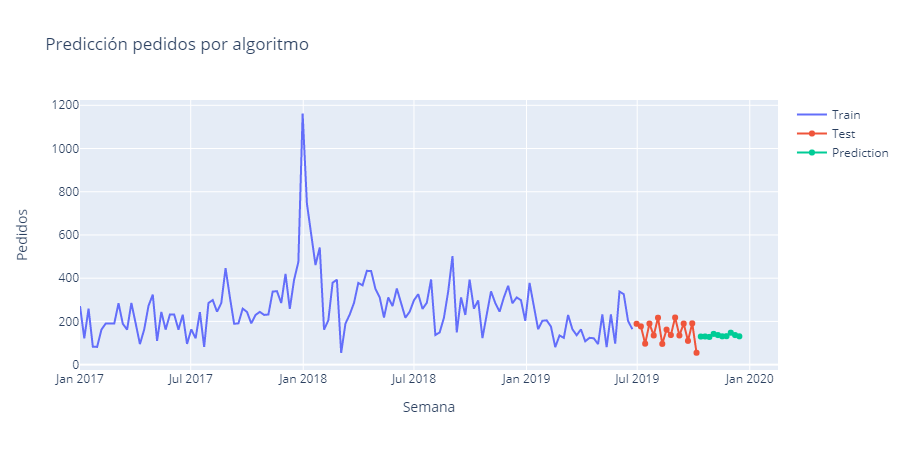

In [25]:
charts = [
	go.Scatter(
		x = Y_train.index,
		y = Y_train,
		name = 'Train'
	),
	go.Scatter(
		x = Y_test.index,
		y = Y_test,
		name = 'Test'
	),
	go.Scatter(
		x = result.index,
		y = result.orders,
		name = 'Prediction'
	)
]

fig = go.Figure(
	data = charts,
	layout = go.Layout(
		title = 'Predicción pedidos por algoritmo',
		xaxis_title = 'Semana',
		yaxis_title = 'Pedidos'
	)
)

fig

In [26]:
import joblib

In [27]:
joblib.dump(xgb_model, './models/xgboost_model.pkl')
# joblib.dump(features, './models/xgboost_features.pkl')

NameError: name 'features' is not defined

# Light GBM Model

In [ ]:
lgb_fit_params={
	"early_stopping_rounds" : 500, 
	"eval_metric" : 'rmse', 
	"eval_set" : [(X_test, Y_test)],
	'eval_names': ['valid'],
	'verbose' : 20
}

In [ ]:
lgb_params = {
	'boosting_type': 'gbdt',
	'objective': 'regression',
	'metric': 'rmse',
	'verbose': 0,
	'bagging_fraction': 0.8,
	'bagging_freq': 1,
	'lambda_l1': 0.01,
	'lambda_l2': 0.01,
	'learning_rate': 0.001,
	'max_bin': 255,
	'max_depth': 6,
	'min_data_in_bin': 1,
	'min_data_in_leaf': 1,
	'num_leaves': 31
}

In [ ]:
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

In [ ]:
clf_lgb = LGBMRegressor(n_estimators=10000, **lgb_params, random_state=0, n_jobs=-1)

In [ ]:
clf_lgb.fit(X_train, Y_train, **lgb_fit_params)

In [ ]:
lgb_model = LGBMRegressor(
	bagging_fraction=0.8, 
	bagging_freq=1, 
	lambda_l1=0.01,
	lambda_l2=0.01, 
	learning_rate=0.01, 
	max_bin=255, 
	max_depth=6,
    metric='rmse', 
	min_data_in_bin=1, 
	min_data_in_leaf=1,
    n_estimators=10000, 
	objective='regression',
    random_state=0, 
	verbose=0
)

In [ ]:
lgb_model.fit(X_train,Y_train)

In [ ]:
lgm_preds = lgb_model.predict(X_test)
lgm_preds = np.exp(lgm_preds)

In [ ]:
lgm_preds = pd.DataFrame(lgm_preds)
lgm_preds.index = Y_test.index

In [ ]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Y_train)
plt.plot(Y_test, label='Original')
plt.plot(xgb_preds, color='cyan', label="xgb_prediction")
plt.plot(lgm_preds, color='red', label='light_lgm_prediction')
plt.legend(loc='best')

# Cat Regressor

In [ ]:
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

In [ ]:
cat_model=CatBoostRegressor()
cat_model.fit(X_train, Y_train)

In [ ]:
cat_preds = cat_model.predict(X_test)
cat_preds = np.exp(cat_preds)

In [ ]:
cat_preds = pd.DataFrame(cat_preds)
cat_preds.index = Y_test.index

In [ ]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Y_train)
plt.plot(Y_test, label='Original')
plt.plot(xgb_preds, color='cyan', label="xgb_prediction")
plt.plot(lgm_preds, color='red', label='light_lgm_prediction')
plt.plot(cat_preds, color='green', label='cat_prediction')
plt.legend(loc='best')

# Random forest Regression

In [ ]:
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

In [65]:
rf_regressor = RandomForestRegressor(n_estimators = 10, random_state=0)
rf_regressor.fit(X_train, Y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
rf_preds = rf_regressor.predict(X_test)
rf_preds = np.exp(rf_preds)

In [ ]:
rf_preds = pd.DataFrame(rf_preds)
rf_preds.index = Y_test.index

In [ ]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Y_train)
plt.plot(Y_test, label='Original')
plt.plot(xgb_preds, color='cyan', label="xgb_prediction")
plt.plot(lgm_preds, color='red', label='light_lgm_prediction')
plt.plot(cat_preds, color='green', label='cat_prediction')
plt.plot(rf_preds, color='pink', label='rf_prediction')
plt.legend(loc='best')

# Elastic net

In [ ]:
from sklearn.linear_model import ElasticNet

In [ ]:
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

In [ ]:
elastic_regressor = ElasticNet(random_state = 0)
elastic_regressor.fit(X_train, Y_train)

In [ ]:
elastic_preds = elastic_regressor.predict(X_test)
elastic_preds = np.exp(elastic_preds)

In [ ]:
elastic_preds = pd.DataFrame(elastic_preds)
elastic_preds.index = Y_test.index

In [ ]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Y_train)
plt.plot(Y_test, label='Original')
plt.plot(xgb_preds, color='cyan', label="xgb_prediction")
plt.plot(lgm_preds, color='red', label='light_lgm_prediction')
plt.plot(cat_preds, color='green', label='cat_prediction')
plt.plot(rf_preds, color='pink', label='rf_prediction')
plt.plot(elastic_preds, color='brown', label='elastic_net_prediction')
plt.legend(loc='best')

In [44]:
Y_train.index

DatetimeIndex(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
               '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
               '2017-02-26', '2017-03-05',
               ...
               '2019-04-21', '2019-04-28', '2019-05-05', '2019-05-12',
               '2019-05-19', '2019-05-26', '2019-06-02', '2019-06-09',
               '2019-06-16', '2019-06-23'],
              dtype='datetime64[ns]', name='date', length=130, freq=None)

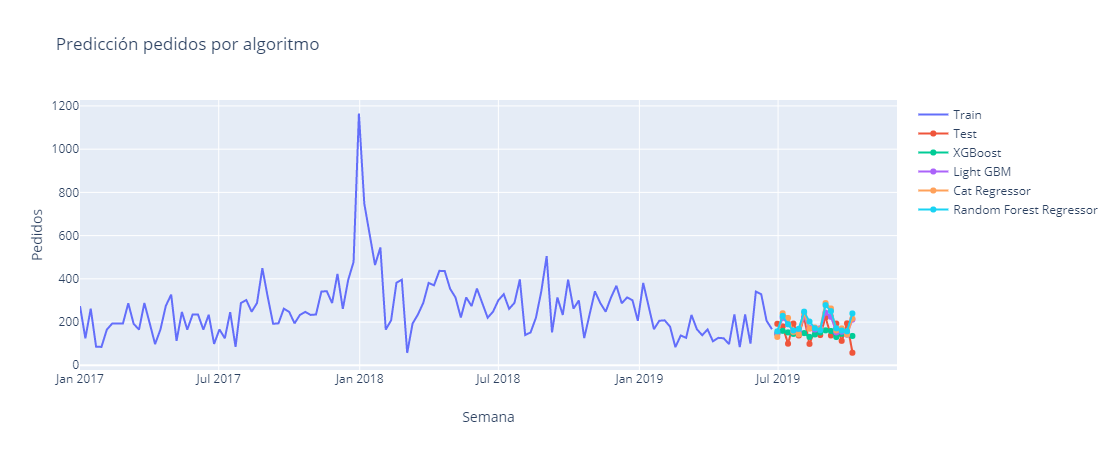

In [46]:
charts = [
	go.Scatter(
		x = Y_train.index,
		y = Y_train,
		name = 'Train'
	),
	go.Scatter(
		x = Y_test.index,
		y = Y_test,
		name = 'Test'
	),
	go.Scatter(
		x = xgb_preds.index,
		y = xgb_preds[0],
		name = 'XGBoost'
	),
	go.Scatter(
		x = lgm_preds.index,
		y = lgm_preds[0],
		name = 'Light GBM'
	),
	go.Scatter(
		x = cat_preds.index,
		y = cat_preds[0],
		name = 'Cat Regressor'
	),
	go.Scatter(
		x = rf_preds.index,
		y = rf_preds[0],
		name = 'Random Forest Regressor'
	)
]

fig = go.Figure(
	data = charts,
	layout = go.Layout(
		title = 'Predicción pedidos por algoritmo',
		xaxis_title = 'Semana',
		yaxis_title = 'Pedidos'
	)
)

fig

In [47]:
def calculate_prediction(models):
	result = pd.concat(models)
	result = result.rename(columns={0 : 'orders'})
	result = result.groupby('date').agg('mean')
	
	return result

In [48]:
calculate_prediction([xgb_preds.reset_index(), lgm_preds.reset_index(), cat_preds.reset_index(), rf_preds.reset_index()])

orders
date                  
2019-06-30  145.222605
2019-07-07  212.073639
2019-07-14  188.304553
2019-07-21  154.521001
2019-07-28  153.960203
2019-08-04  215.254309
2019-08-11  168.985704
2019-08-18  163.635570
2019-08-25  163.239373
2019-09-01  242.735493
2019-09-08  224.082702
2019-09-15  153.827285
2019-09-22  158.065371
2019-09-29  146.352118
2019-10-06  200.763208

In [49]:
result = pd.concat([xgb_preds.reset_index(), lgm_preds.reset_index(), cat_preds.reset_index(), rf_preds.reset_index()])

In [50]:
result = result.rename(columns={0 : 'orders'})

In [51]:
result = result.groupby('date').agg('mean')

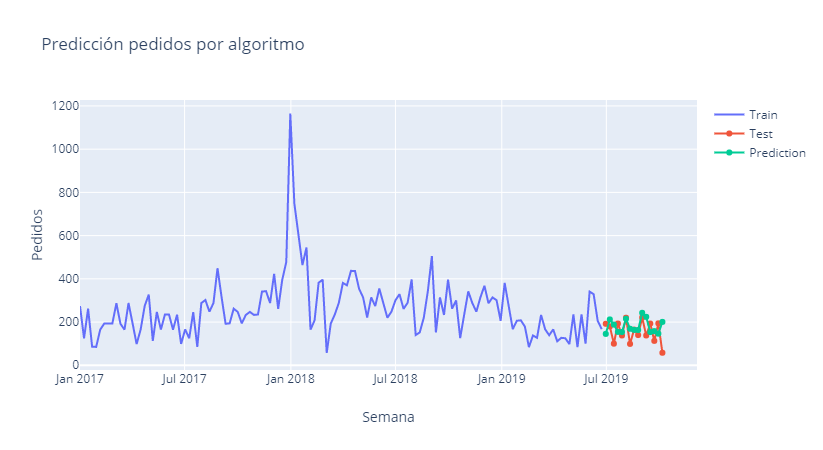

In [52]:
charts = [
	go.Scatter(
		x = Y_train.index,
		y = Y_train,
		name = 'Train'
	),
	go.Scatter(
		x = Y_test.index,
		y = Y_test,
		name = 'Test'
	),
	go.Scatter(
		x = result.index,
		y = result.orders,
		name = 'Prediction'
	)
]

fig = go.Figure(
	data = charts,
	layout = go.Layout(
		title = 'Predicción pedidos por algoritmo',
		xaxis_title = 'Semana',
		yaxis_title = 'Pedidos'
	)
)

fig

In [54]:
print(np.sqrt(mean_squared_error(Y_test, result)))

59.054808263310996


In [77]:
def get_predictions(model, df, date_index):
	preds = model.predict(df)
	preds = np.exp(preds)
	
	preds = pd.DataFrame(preds)
	preds.index = date_index
	
	return preds

In [79]:
xgb_preds = get_predictions(xgb_model, df_test_processed, df_test_processed.index)
lgb_preds = get_predictions(lgb_model, df_test_processed, df_test_processed.index)
cat_preds = get_predictions(cat_model, df_test_processed, df_test_processed.index)
rf_preds = get_predictions(rf_regressor, df_test_processed, df_test_processed.index)

In [81]:
result = calculate_prediction([xgb_preds.reset_index(), lgm_preds.reset_index(), cat_preds.reset_index(), rf_preds.reset_index()])

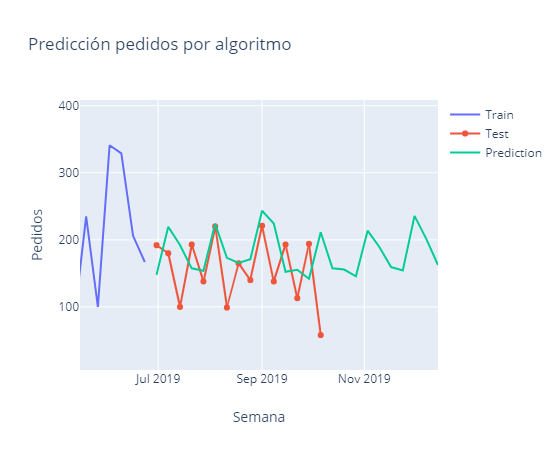

In [82]:
charts = [
	go.Scatter(
		x = Y_train.index,
		y = Y_train,
		name = 'Train'
	),
	go.Scatter(
		x = Y_test.index,
		y = Y_test,
		name = 'Test'
	),
	go.Scatter(
		x = result.index,
		y = result.orders,
		name = 'Prediction'
	)
]

fig = go.Figure(
	data = charts,
	layout = go.Layout(
		title = 'Predicción pedidos por algoritmo',
		xaxis_title = 'Semana',
		yaxis_title = 'Pedidos'
	)
)

fig

# Linear regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
lr = LinearRegression()  
lr.fit(X_train, Y_train)

Root Mean Squared Error for LinearRegression: 108.22292251741374


In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print('Root Mean Squared Error for LinearRegression:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))